In [1]:
import os
import gdown
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Input, Dense, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
files_to_download = [
    {'id': '1XP7aWc8AqALFA5HofiC6FQOI5rJ6SVc9', 'name': 'Dataset.zip'},
    {'id': '1pzknl3RgnAmMEutPoKJ0iiPcDepDAN8y', 'name': 'idm_baru.csv'}
]

def download_file(file_id, output_file):
    download_url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(download_url, output_file, quiet=False)

for file in files_to_download:
    download_file(file['id'], file['name'])

with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall("Data/")

Downloading...
From: https://drive.google.com/uc?id=1XP7aWc8AqALFA5HofiC6FQOI5rJ6SVc9
To: c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\Dataset.zip
100%|██████████| 5.17M/5.17M [00:20<00:00, 258kB/s] 
Downloading...
From: https://drive.google.com/uc?id=1pzknl3RgnAmMEutPoKJ0iiPcDepDAN8y
To: c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\idm_baru.csv
100%|██████████| 74.1k/74.1k [00:03<00:00, 22.2kB/s]


In [3]:
day_path = 'Data/Dataset/Daylight'
night_path = 'Data/Dataset/NTL'
metadata = 'Data/idm_baru.csv'

In [4]:
idm_df = pd.read_csv(metadata)
idm_df.head()

,KABUPATEN,KECAMATAN,KODE BPS,DESA,IKS,IKE,IKL,IDM,KATEGORI IDM,BINARY STATUS
0,ACEH UTARA,SAWANG,1111010001,RISEH TUNONG,0.56,3667.00,3333.0,0.42,SANGAT TERTINGGAL,TERTINGGAL
1,ACEH UTARA,SAWANG,1111010002,GUNCI,7029.00,4167.00,3333.0,4843.00,SANGAT TERTINGGAL,TERTINGGAL
2,ACEH UTARA,SAWANG,1111010003,KUBU,6914.00,4667.00,4667.0,5416.00,TERTINGGAL,TERTINGGAL
3,ACEH UTARA,SAWANG,1111010004,BLANG CUT,6514.00,3333.00,4667.0,4838.00,SANGAT TERTINGGAL,TERTINGGAL
4,ACEH UTARA,SAWANG,1111010005,RISEH TEUNGOH,5714.00,0.45,5333.0,5183.00,TERTINGGAL,TERTINGGAL


In [5]:
idm_df_filtered = idm_df[['KODE BPS', 'KECAMATAN', 'DESA', 'BINARY STATUS']]
idm_df_filtered

,KODE BPS,KECAMATAN,DESA,BINARY STATUS
0,1111010001,SAWANG,RISEH TUNONG,TERTINGGAL
1,1111010002,SAWANG,GUNCI,TERTINGGAL
2,1111010003,SAWANG,KUBU,TERTINGGAL
3,1111010004,SAWANG,BLANG CUT,TERTINGGAL
4,1111010005,SAWANG,RISEH TEUNGOH,TERTINGGAL
...,...,...,...,...
846,1111041003,GEUREDONG PASE,KRUENG MBANG,TERTINGGAL
847,1111041002,GEUREDONG PASE,PULO MEURIA,TERTINGGAL
848,1111041001,GEUREDONG PASE,SUKA DAMAI,MAJU
849,1111022002,BANDA BARO,ALUE KEURINYAI,MAJU


In [6]:
def match_images_with_metadata(image_files, metadata, is_night=False):
    image_data = []
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        if is_night:
            village_code = img_name.split('.')[0]
        else:
            village_code = img_name.split('-')[0]
        village_info = metadata[metadata['KODE BPS'] == int(village_code)]
        if not village_info.empty:
            kecamatan = village_info['KECAMATAN'].values[0]
            desa = village_info['DESA'].values[0]
            status = village_info['BINARY STATUS'].values[0]
            image_data.append({
                'filename': img_name,
                'filepath': img_path,
                'kecamatan': kecamatan,
                'desa': desa,
                'status': status
            })
    return pd.DataFrame(image_data)

In [7]:
day_files = []
for root, dirs, files in os.walk(day_path):
    for file in files:
        day_files.append(os.path.join(root, file))

day_files[:10]

['Data/Dataset/Daylight\\MAJU\\1111010008-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010008-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010023-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010023-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010024-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010024-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010027-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010027-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010034-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010034-s.png']

In [8]:
night_files = []
for root, dirs, files in os.walk(night_path):
    for file in files:
        night_files.append(os.path.join(root, file))

night_files[:10]

['Data/Dataset/NTL\\MAJU\\1111010008.png',
 'Data/Dataset/NTL\\MAJU\\1111010023.png',
 'Data/Dataset/NTL\\MAJU\\1111010024.png',
 'Data/Dataset/NTL\\MAJU\\1111010027.png',
 'Data/Dataset/NTL\\MAJU\\1111010034.png',
 'Data/Dataset/NTL\\MAJU\\1111020014.png',
 'Data/Dataset/NTL\\MAJU\\1111020019.png',
 'Data/Dataset/NTL\\MAJU\\1111020023.png',
 'Data/Dataset/NTL\\MAJU\\1111020025.png',
 'Data/Dataset/NTL\\MAJU\\1111020026.png']

In [9]:
day_images_metadata = match_images_with_metadata(day_files, idm_df_filtered)
day_images_metadata

,filename,filepath,kecamatan,desa,status
0,1111010008-l.png,Data/Dataset/Daylight\MAJU\1111010008-l.png,SAWANG,SAWANG,MAJU
1,1111010008-s.png,Data/Dataset/Daylight\MAJU\1111010008-s.png,SAWANG,SAWANG,MAJU
2,1111010023-l.png,Data/Dataset/Daylight\MAJU\1111010023-l.png,SAWANG,MEUNASAH PULO,MAJU
3,1111010023-s.png,Data/Dataset/Daylight\MAJU\1111010023-s.png,SAWANG,MEUNASAH PULO,MAJU
4,1111010024-l.png,Data/Dataset/Daylight\MAJU\1111010024-l.png,SAWANG,LHOK KUYUN,MAJU
...,...,...,...,...,...
1697,1111170010-s.png,Data/Dataset/Daylight\TERTINGGAL\1111170010-s.png,DEWANTARA,GEULUMPANG SULU BARAT,TERTINGGAL
1698,1111170014-l.png,Data/Dataset/Daylight\TERTINGGAL\1111170014-l.png,DEWANTARA,BANGKA JAYA,TERTINGGAL
1699,1111170014-s.png,Data/Dataset/Daylight\TERTINGGAL\1111170014-s.png,DEWANTARA,BANGKA JAYA,TERTINGGAL
1700,1111170015-l.png,Data/Dataset/Daylight\TERTINGGAL\1111170015-l.png,DEWANTARA,BLUKA TEUBAI,TERTINGGAL


In [10]:
night_images_metadata = match_images_with_metadata(night_files, idm_df_filtered, is_night=True)
night_images_metadata

,filename,filepath,kecamatan,desa,status
0,1111010008.png,Data/Dataset/NTL\MAJU\1111010008.png,SAWANG,SAWANG,MAJU
1,1111010023.png,Data/Dataset/NTL\MAJU\1111010023.png,SAWANG,MEUNASAH PULO,MAJU
2,1111010024.png,Data/Dataset/NTL\MAJU\1111010024.png,SAWANG,LHOK KUYUN,MAJU
3,1111010027.png,Data/Dataset/NTL\MAJU\1111010027.png,SAWANG,BABAH BULOH,MAJU
4,1111010034.png,Data/Dataset/NTL\MAJU\1111010034.png,SAWANG,ULEE GEUDONG,MAJU
...,...,...,...,...,...
846,1111170008.png,Data/Dataset/NTL\TERTINGGAL\1111170008.png,DEWANTARA,ULEE REULEUNG,TERTINGGAL
847,1111170009.png,Data/Dataset/NTL\TERTINGGAL\1111170009.png,DEWANTARA,LANCANG BARAT,TERTINGGAL
848,1111170010.png,Data/Dataset/NTL\TERTINGGAL\1111170010.png,DEWANTARA,GEULUMPANG SULU BARAT,TERTINGGAL
849,1111170014.png,Data/Dataset/NTL\TERTINGGAL\1111170014.png,DEWANTARA,BANGKA JAYA,TERTINGGAL


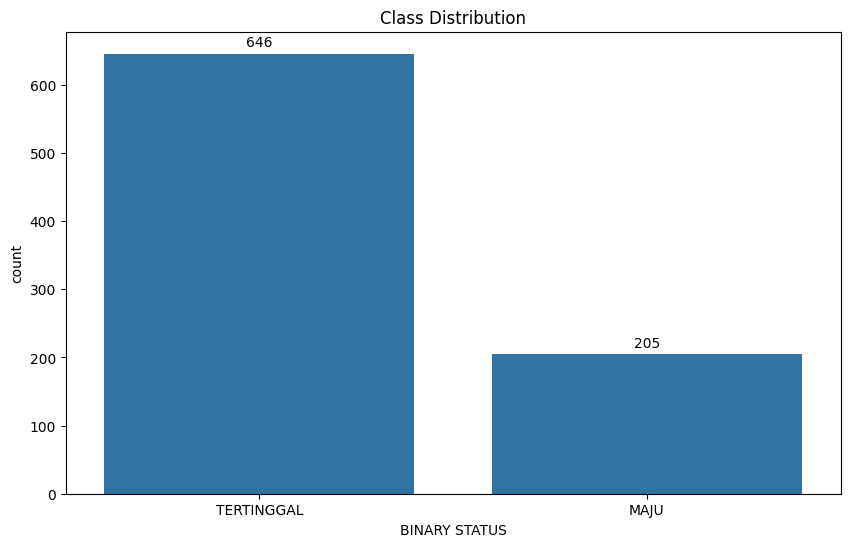

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='BINARY STATUS', data=idm_df_filtered)
plt.title('Class Distribution')
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

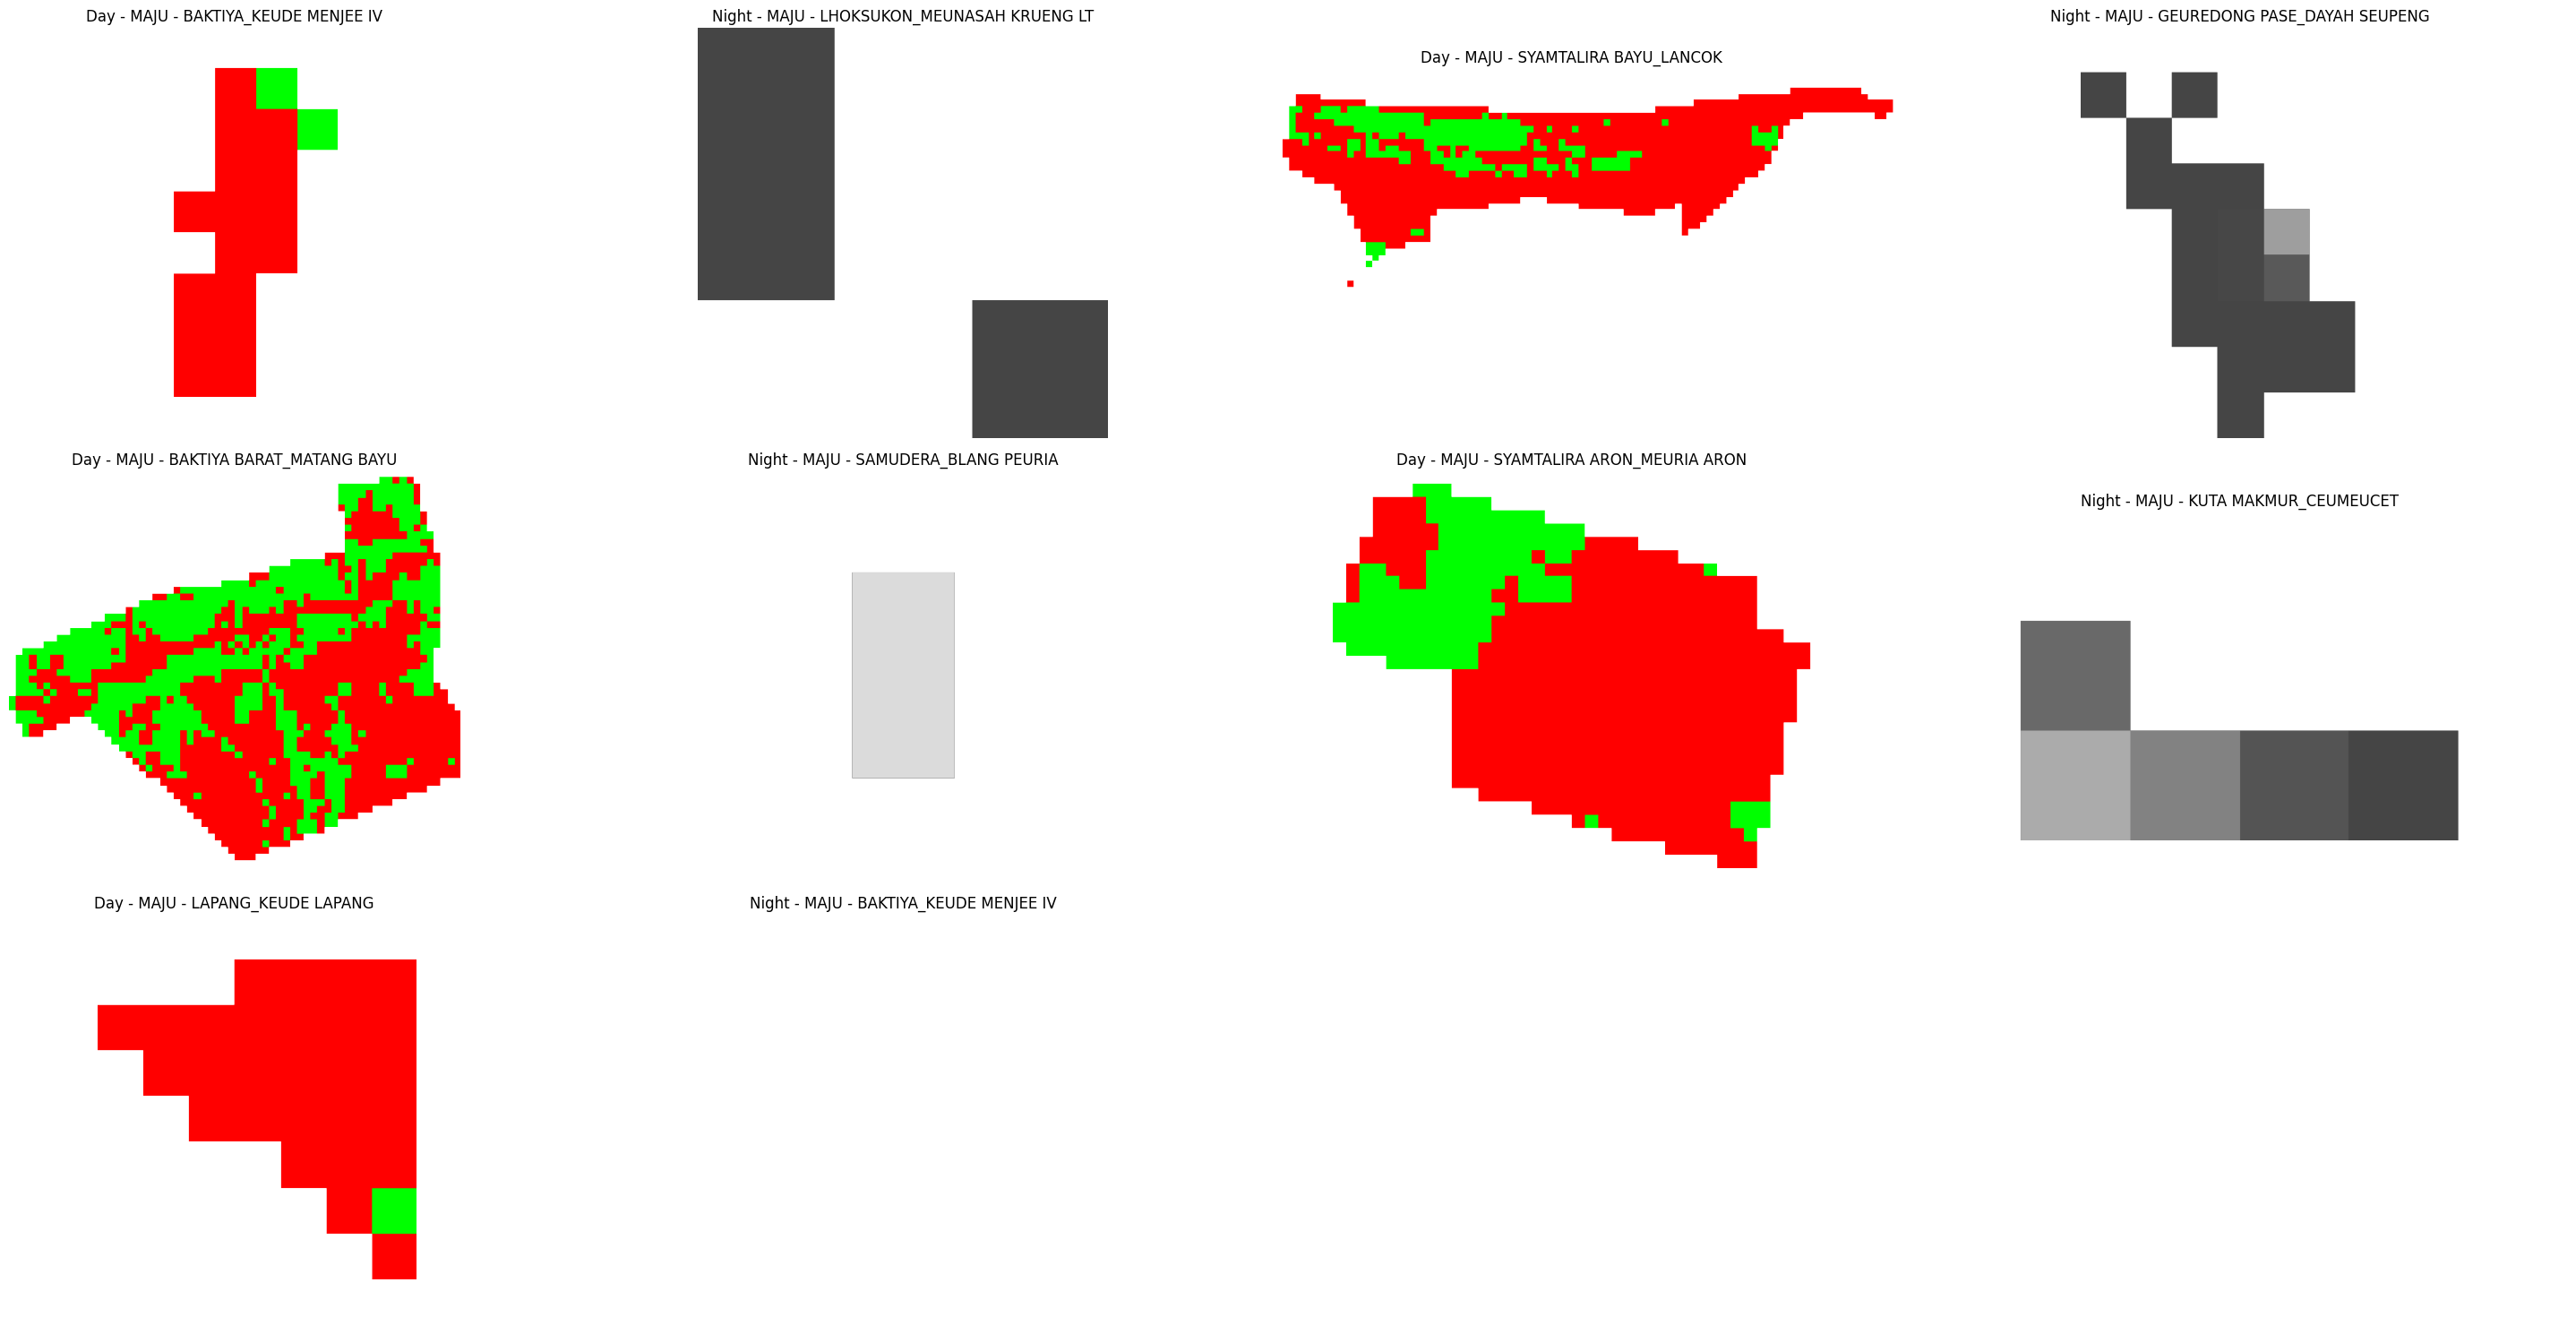

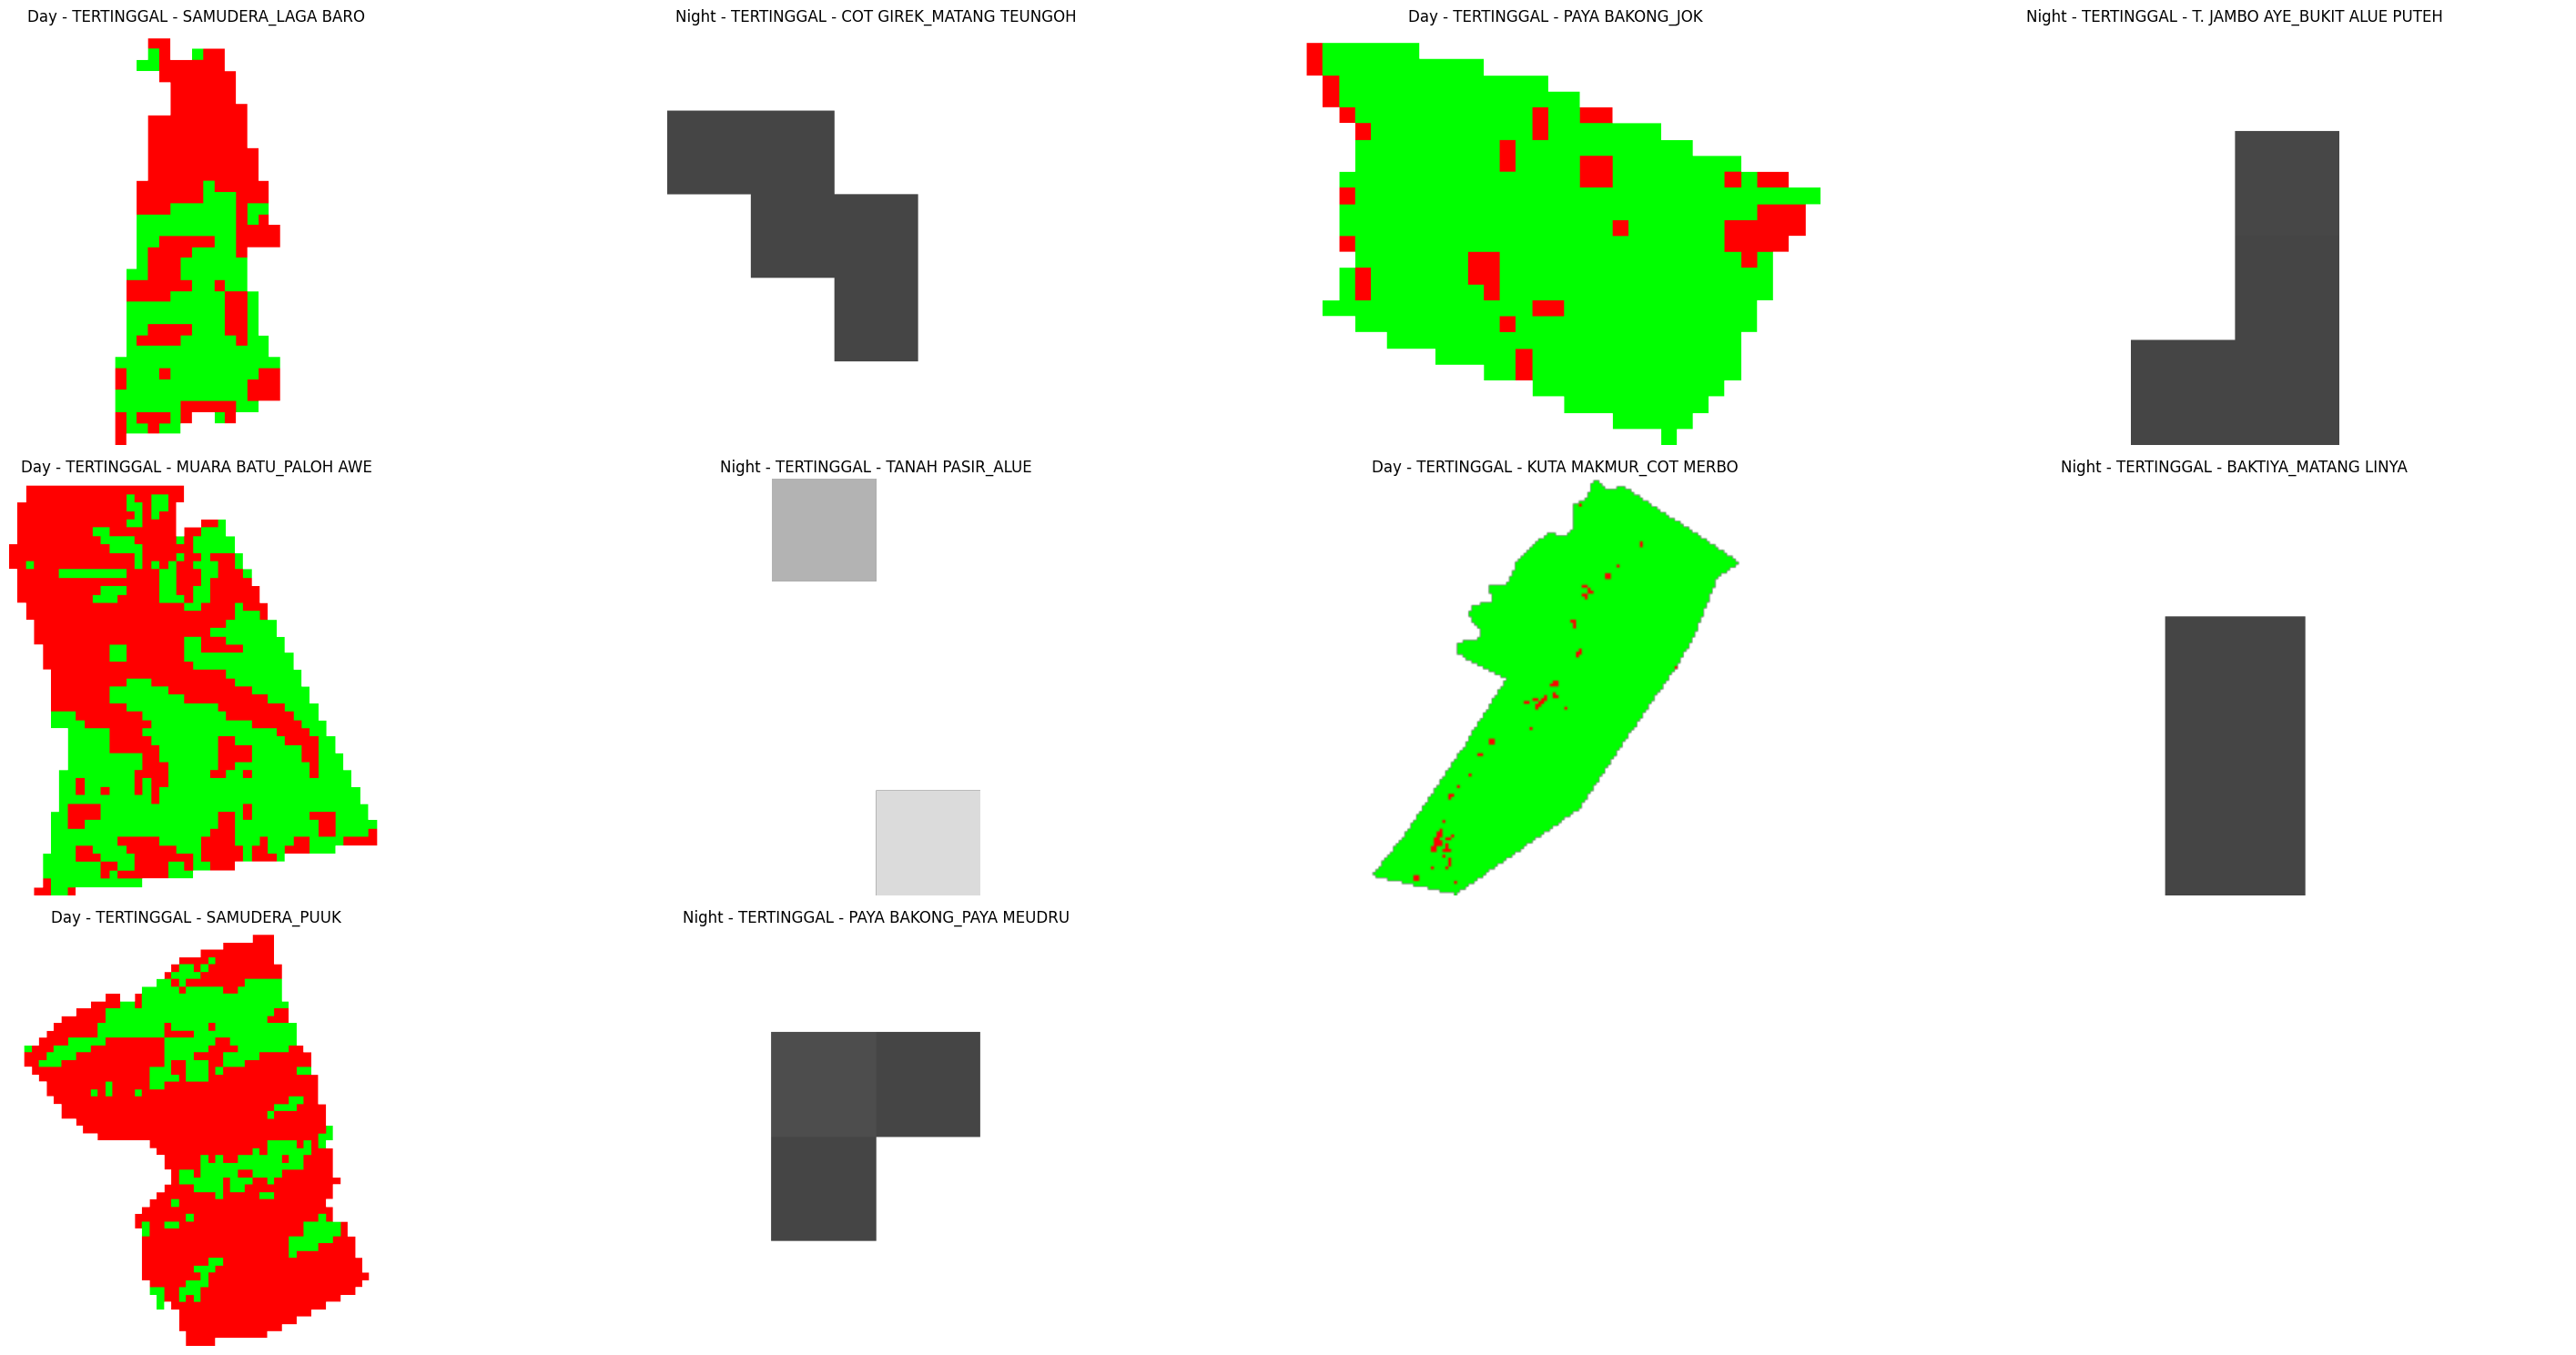

In [12]:
def show_sample_images(day_image_data, night_image_data, class_label, n=5, cols=2):
    class_images_day = day_image_data[day_image_data['status'] == class_label]
    class_images_night = night_image_data[night_image_data['status'] == class_label]
    
    sample_images_day = class_images_day.sample(n)
    sample_images_night = class_images_night.sample(n)
    
    rows = (n // cols) + (n % cols > 0)
    fig, axes = plt.subplots(rows, cols*2, figsize=(30, 5*rows))
    axes = axes.flatten()
    
    for i, ((_, day_row), (_, night_row)) in enumerate(zip(sample_images_day.iterrows(), sample_images_night.iterrows())):
        # Day images
        img_path_day = day_row['filepath']
        img_day = Image.open(img_path_day)
        ax_day = axes[i*2]
        ax_day.imshow(img_day)
        ax_day.set_title(f"Day - {class_label} - {day_row['kecamatan']}_{day_row['desa']}")
        ax_day.axis('off')
        
        # Night images
        img_path_night = night_row['filepath']
        img_night = Image.open(img_path_night)
        ax_night = axes[i*2 + 1]
        ax_night.imshow(img_night)
        ax_night.set_title(f"Night - {class_label} - {night_row['kecamatan']}_{night_row['desa']}")
        ax_night.axis('off')
    
    for ax in axes[len(sample_images_day)*2:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images(day_images_metadata, night_images_metadata, 'MAJU', n=5, cols=2)
show_sample_images(day_images_metadata, night_images_metadata, 'TERTINGGAL', n=5, cols=2)


## Balancing Dataset

### Tes 1

In [13]:
def augment_images_in_batches(image_paths, datagen, augment_size, batch_size=25):
    augmented_images = []
    num_batches = len(image_paths) // batch_size + (len(image_paths) % batch_size > 0)
    
    for i in range(num_batches):
        batch_paths = image_paths[i * batch_size:(i + 1) * batch_size]
        batch_images = []
        
        for img_path in batch_paths:
            img = Image.open(img_path)
            
            if img.mode == 'RGBA':
                img = img.convert('RGB')
            
            x = np.array(img)
            x = x.reshape((1,) + x.shape)
            
            for _ in range(augment_size // batch_size):
                for batch in datagen.flow(x, batch_size=1):
                    batch_images.append(batch[0])
                    break
        
        augmented_images.extend(batch_images)
        
        if len(augmented_images) >= augment_size:
            break
    
    return augmented_images[:augment_size]

In [14]:
augment_size = len(day_images_metadata[day_images_metadata['status'] == 'TERTINGGAL']) - len(day_images_metadata[day_images_metadata['status'] == 'MAJU'])

maju_day_images = day_images_metadata[day_images_metadata['status'] == 'MAJU']['filepath'].tolist()
maju_night_images = night_images_metadata[night_images_metadata['status'] == 'MAJU']['filepath'].tolist()

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
augmented_day_images = augment_images_in_batches(maju_day_images, datagen, augment_size)
augmented_night_images = augment_images_in_batches(maju_night_images, datagen, augment_size)

In [23]:
augmented_day_df = pd.DataFrame({
    'filename': [f"aug_day_{i}.png" for i in range(len(augmented_day_images))],
    'kecamatan': ['Augmented'] * len(augmented_day_images),
    'desa': ['Augmented'] * len(augmented_day_images),
    'status': ['MAJU'] * len(augmented_day_images)
})

augmented_night_df = pd.DataFrame({
    'filename': [f"aug_night_{i}.png" for i in range(len(augmented_night_images))],
    'kecamatan': ['Augmented'] * len(augmented_night_images),
    'desa': ['Augmented'] * len(augmented_night_images),
    'status': ['MAJU'] * len(augmented_night_images)
})

In [24]:
balanced_day_images_metadata = pd.concat([day_images_metadata, augmented_day_df])
balanced_night_images_metadata = pd.concat([night_images_metadata, augmented_night_df])

In [27]:
X_day_train, X_day_test, y_train, y_test = train_test_split(balanced_day_images_metadata['filename'], balanced_day_images_metadata['status'], test_size=0.2, stratify=balanced_day_images_metadata['status'], random_state=42)
X_night_train, X_night_test, _, _ = train_test_split(balanced_night_images_metadata['filename'], balanced_night_images_metadata['status'], test_size=0.2, stratify=balanced_night_images_metadata['status'], random_state=42)

In [29]:
def create_data_generator(filenames, labels, batch_size, datagen):
    df = pd.DataFrame({'filename': filenames, 'label': labels}).reset_index(drop=True)
    generator = datagen.flow_from_dataframe(
        df,
        x_col='filename',
        y_col='label',
        target_size=(255, 255),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True
    )
    return generator

train_gen_day = create_data_generator(X_day_train, y_train, 32, datagen)
test_gen_day = create_data_generator(X_day_test, y_test, 32, datagen)

train_gen_night = create_data_generator(X_night_train, y_train, 32, datagen)
test_gen_night = create_data_generator(X_night_test, y_test, 32, datagen)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2067 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 517 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


ValueError: cannot reindex on an axis with duplicate labels

### Tes 2

In [30]:
# Data Augmentation
augment_size = len(day_images_metadata[day_images_metadata['status'] == 'TERTINGGAL']) - len(day_images_metadata[day_images_metadata['status'] == 'MAJU'])

maju_day_images = day_images_metadata[day_images_metadata['status'] == 'MAJU']['filepath'].tolist()
maju_night_images = night_images_metadata[night_images_metadata['status'] == 'MAJU']['filepath'].tolist()

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_day_images = augment_images_in_batches(maju_day_images, datagen, augment_size)
augmented_night_images = augment_images_in_batches(maju_night_images, datagen, augment_size)

augmented_day_df = pd.DataFrame({
    'filename': [f"aug_day_{i}.png" for i in range(len(augmented_day_images))],
    'kecamatan': ['Augmented'] * len(augmented_day_images),
    'desa': ['Augmented'] * len(augmented_day_images),
    'status': ['MAJU'] * len(augmented_day_images)
})

augmented_night_df = pd.DataFrame({
    'filename': [f"aug_night_{i}.png" for i in range(len(augmented_night_images))],
    'kecamatan': ['Augmented'] * len(augmented_night_images),
    'desa': ['Augmented'] * len(augmented_night_images),
    'status': ['MAJU'] * len(augmented_night_images)
})

balanced_day_images_metadata = pd.concat([day_images_metadata, augmented_day_df])
balanced_night_images_metadata = pd.concat([night_images_metadata, augmented_night_df])

In [31]:
X_day_train, X_day_test, y_day_train, y_day_test = train_test_split(balanced_day_images_metadata['filename'], balanced_day_images_metadata['status'], test_size=0.2, stratify=balanced_day_images_metadata['status'], random_state=42)
X_night_train, X_night_test, y_night_train, y_night_test = train_test_split(balanced_night_images_metadata['filename'], balanced_night_images_metadata['status'], test_size=0.2, stratify=balanced_night_images_metadata['status'], random_state=42)

In [32]:
def create_data_generator(filenames, labels, batch_size, datagen):
    df = pd.DataFrame({'filename': filenames, 'label': labels}).reset_index(drop=True)
    generator = datagen.flow_from_dataframe(
        df,
        x_col='filename',
        y_col='label',
        target_size=(255, 255),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True
    )
    return generator

train_gen_day = create_data_generator(X_day_train, y_day_train, 32, datagen)
test_gen_day = create_data_generator(X_day_test, y_day_test, 32, datagen)

train_gen_night = create_data_generator(X_night_train, y_night_train, 32, datagen)
test_gen_night = create_data_generator(X_night_test, y_night_test, 32, datagen)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2067 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 517 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1386 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 347 invalid image filename(s) in x_col="filename". These file

In [35]:
def combined_generator(day_gen, night_gen):
    while True:
        day_images, day_labels = next(day_gen)
        night_images, night_labels = next(night_gen)
        
        yield [day_images, night_images], day_labels  # assuming day_labels and night_labels are the same

# Create the combined generators
train_combined_gen = combined_generator(train_gen_day, train_gen_night)
val_combined_gen = combined_generator(test_gen_day, test_gen_night)

### Tes 3

In [39]:
augment_size = len(day_images_metadata[day_images_metadata['status'] == 'TERTINGGAL']) - len(day_images_metadata[day_images_metadata['status'] == 'MAJU'])

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [40]:
def augment_images_in_batches(image_paths, datagen, augment_size, batch_size=25):
    augmented_images = []
    num_batches = len(image_paths) // batch_size + (len(image_paths) % batch_size > 0)
    
    for i in range(num_batches):
        batch_paths = image_paths[i * batch_size:(i + 1) * batch_size]
        batch_images = []
        
        for img_path in batch_paths:
            img = Image.open(img_path)
            
            if img.mode == 'RGBA':
                img = img.convert('RGB')
            
            x = np.array(img)
            x = x.reshape((1,) + x.shape)
            
            for _ in range(augment_size // batch_size):
                for batch in datagen.flow(x, batch_size=1):
                    batch_images.append(batch[0])
                    break
        
        augmented_images.extend(batch_images)
        
        if len(augmented_images) >= augment_size:
            break
    
    return augmented_images[:augment_size]


In [41]:
maju_day_images = day_images_metadata[day_images_metadata['status'] == 'MAJU']['filepath'].tolist()
maju_night_images = night_images_metadata[night_images_metadata['status'] == 'MAJU']['filepath'].tolist()

augmented_day_images = augment_images_in_batches(maju_day_images, datagen, augment_size)
augmented_night_images = augment_images_in_batches(maju_night_images, datagen, augment_size)

In [42]:
augmented_day_df = pd.DataFrame({
    'filepath': [f"aug_day_{i}.png" for i in range(len(augmented_day_images))],
    'kecamatan': ['Augmented'] * len(augmented_day_images),
    'desa': ['Augmented'] * len(augmented_day_images),
    'status': ['MAJU'] * len(augmented_day_images)
})

augmented_night_df = pd.DataFrame({
    'filepath': [f"aug_night_{i}.png" for i in range(len(augmented_night_images))],
    'kecamatan': ['Augmented'] * len(augmented_night_images),
    'desa': ['Augmented'] * len(augmented_night_images),
    'status': ['MAJU'] * len(augmented_night_images)
})

In [43]:
balanced_day_images_metadata = pd.concat([day_images_metadata, augmented_day_df])
balanced_night_images_metadata = pd.concat([night_images_metadata, augmented_night_df])

In [44]:
X_day_train, X_day_test, y_day_train, y_day_test = train_test_split(balanced_day_images_metadata['filepath'], balanced_day_images_metadata['status'], test_size=0.2, stratify=balanced_day_images_metadata['status'], random_state=42)
X_night_train, X_night_test, y_night_train, y_night_test = train_test_split(balanced_night_images_metadata['filepath'], balanced_night_images_metadata['status'], test_size=0.2, stratify=balanced_night_images_metadata['status'], random_state=42)

In [45]:
def create_data_generator(filenames, labels, batch_size, datagen):
    df = pd.DataFrame({'filename': filenames, 'label': labels}).reset_index(drop=True)
    generator = datagen.flow_from_dataframe(
        df,
        x_col='filename',
        y_col='label',
        target_size=(255, 255),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True
    )
    return generator

train_gen_day = create_data_generator(X_day_train, y_day_train, 32, datagen)
test_gen_day = create_data_generator(X_day_test, y_day_test, 32, datagen)

train_gen_night = create_data_generator(X_night_train, y_night_train, 32, datagen)
test_gen_night = create_data_generator(X_night_test, y_night_test, 32, datagen)

Found 1366 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.
Found 688 validated image filenames belonging to 2 classes.
Found 163 validated image filenames belonging to 2 classes.


c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 701 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 181 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 698 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\bps-env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 184 invalid image filename(s) in x_col="filename". These filena

In [63]:
def combined_data_generator(day_gen, night_gen):
    while True:
        day_batch = next(day_gen)
        night_batch = next(night_gen)
        
        yield (day_batch[0], night_batch[0]), day_batch[1]

train_combined_gen = combined_data_generator(train_gen_day, train_gen_night)
test_combined_gen = combined_data_generator(test_gen_day, test_gen_night)

In [60]:
def generator_to_tf_dataset(generator, batch_size):
    output_signature = (
        (tf.TensorSpec(shape=(batch_size, 255, 255, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(batch_size, 255, 255, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
    )
    
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

train_combined_ds = generator_to_tf_dataset(train_combined_gen, 32)
test_combined_ds = generator_to_tf_dataset(test_combined_gen, 32)

In [62]:
for (day_batch, night_batch), labels in train_combined_gen:
    print("Day batch shape:", day_batch.shape)
    print("Night batch shape:", night_batch.shape)
    print("Labels shape:", labels.shape)
    break

Day batch shape: (32, 255, 255, 3)
Night batch shape: (32, 255, 255, 3)
Labels shape: (32,)


## Train Model

In [64]:
input_day = Input(shape=(255, 255, 3), name='day_input')
input_night = Input(shape=(255, 255, 3), name='night_input')

def build_cnn_branch(input_tensor):
    x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    return x

branch_day = build_cnn_branch(input_day)
branch_night = build_cnn_branch(input_night)

combined = Concatenate()([branch_day, branch_night])
output = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[input_day, input_night], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
history = model.fit(
    train_combined_ds,
    epochs=5,
    validation_data=test_combined_ds
)

Epoch 1/5


ValueError: Input 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 255, 255, 3), found shape=(None, 32, 255, 255, 3)